## Data analysis

In [10]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('data_default.csv', header=0)

In [11]:
df.head()

gpu          gemm input mode     m     n     k  \
NVIDIA_GH200_120GB D  normal01   fp64_int8_3     N    N  1024  1024  1024   
                   D  normal01   fp64_int8_9     N    N  1024  1024  1024   
                   D  normal01  fp64_int8_18     N    N  1024  1024  1024   
                   D  normal01         dgemm     N    N  1024  1024  1024   
                   D  normal01   fp64_int8_3     N    N  2048  2048  2048   

                          residual  max_relative  throughput_in_tflops  
NVIDIA_GH200_120GB D  2.401237e-05  2.757648e+01             15.468640  
                   D  2.275485e-16  5.395420e-12              3.109284  
                   D  2.275303e-16  1.286471e-15              0.876498  
                   D  1.066552e-15  9.625805e-10             52.867900  
                   D  2.717785e-05  3.946706e+01             37.601840

In [12]:
df['slices'] = df['gemm'].str.extract(r'fp64_int8_(\d+)').astype(float)
df.loc[df['gemm'] == 'dgemm', 'slices'] = 0

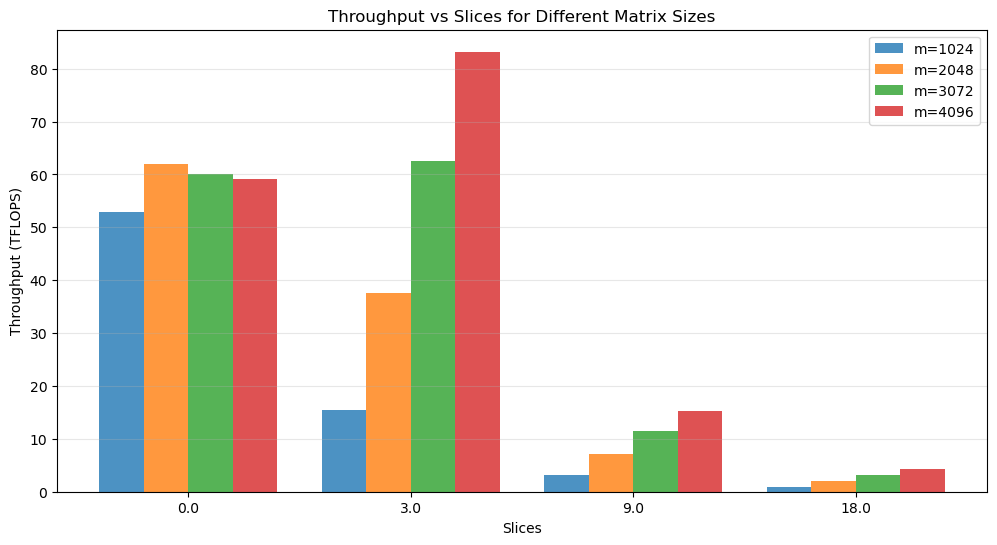

In [13]:
# Get unique matrix sizes (m values)
m_values = df['m'].unique()

# Get unique slice values (excluding NaN)
slice_values = df['slices'].dropna().unique()
slice_values = sorted(slice_values)

plt.figure(figsize=(12, 6))

width = 0.8 / len(m_values)  # Adjust width based on number of m values
x_pos = range(len(slice_values))

# Plot a bar for each m value
for i, m_val in enumerate(m_values):
    df_m = df[df['m'] == m_val].dropna(subset=['slices'])
    
    # Sort by slices to match x_pos
    df_m = df_m.sort_values('slices')
    
    offset = (i - len(m_values)/2 + 0.5) * width
    plt.bar([p + offset for p in x_pos], 
            df_m['throughput_in_tflops'], 
            width, 
            label=f'm={m_val}', 
            alpha=0.8)

plt.xlabel('Slices')
plt.ylabel('Throughput (TFLOPS)')
plt.title('Throughput vs Slices for Different Matrix Sizes')
plt.xticks(x_pos, slice_values)
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()

## GB10 results

In [14]:
# Read data_gb10.csv into a new DataFrame (uses pandas already imported in the notebook)
df_gb10_new = pd.read_csv('data_gb10.csv', header=0)

# Quick check
df_gb10_new.head()

,gpu,gemm,input,slicing,m,n,k,residual,max_relative,throughput_in_tflops
0,NVIDIA_GB10,D,default,fp64_int8_3,1024,1024,1024,2.401237e-05,2.757648e+01,2.825389
1,NVIDIA_GB10,D,default,fp64_int8_9,1024,1024,1024,2.275485e-16,5.395420e-12,0.466159
2,NVIDIA_GB10,D,default,fp64_int8_18,1024,1024,1024,2.275303e-16,1.286471e-15,0.153885
3,NVIDIA_GB10,D,default,dgemm,1024,1024,1024,1.066552e-15,9.625805e-10,0.412760
4,NVIDIA_GB10,D,default,fp64_int8_3,2048,2048,2048,2.717785e-05,3.946706e+01,3.161896


,gpu,m,gemm,throughput_in_tflops,dgemm_throughput,pct_increase_vs_dgemm
3,default,1024,dgemm,0.412760,0.412760,0.000000
2,default,1024,fp64_int8_18,0.153885,0.412760,-62.717984
0,default,1024,fp64_int8_3,2.825389,0.412760,584.510675
1,default,1024,fp64_int8_9,0.466159,0.412760,12.937021
7,default,2048,dgemm,0.407033,0.407033,0.000000
6,default,2048,fp64_int8_18,0.195836,0.407033,-51.887058
4,default,2048,fp64_int8_3,3.161896,0.407033,676.815448
5,default,2048,fp64_int8_9,0.686334,0.407033,68.618670
11,default,4096,dgemm,0.421328,0.421328,0.000000
10,default,4096,fp64_int8_18,0.343025,0.421328,-18.584752
